Dataset: https://www.kaggle.com/c/bike-sharing-demand/overview

In [216]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [217]:
df = pd.read_csv('../datasets/bike-sharing-demand/train.csv')

# EDA: Time Series Analysis

In [218]:
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [220]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


In [221]:
def decompose_bike_sharing_demand(df, share_type='count', samples=250, period=24):
    if samples == 'all':
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid

    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()

    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()

    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

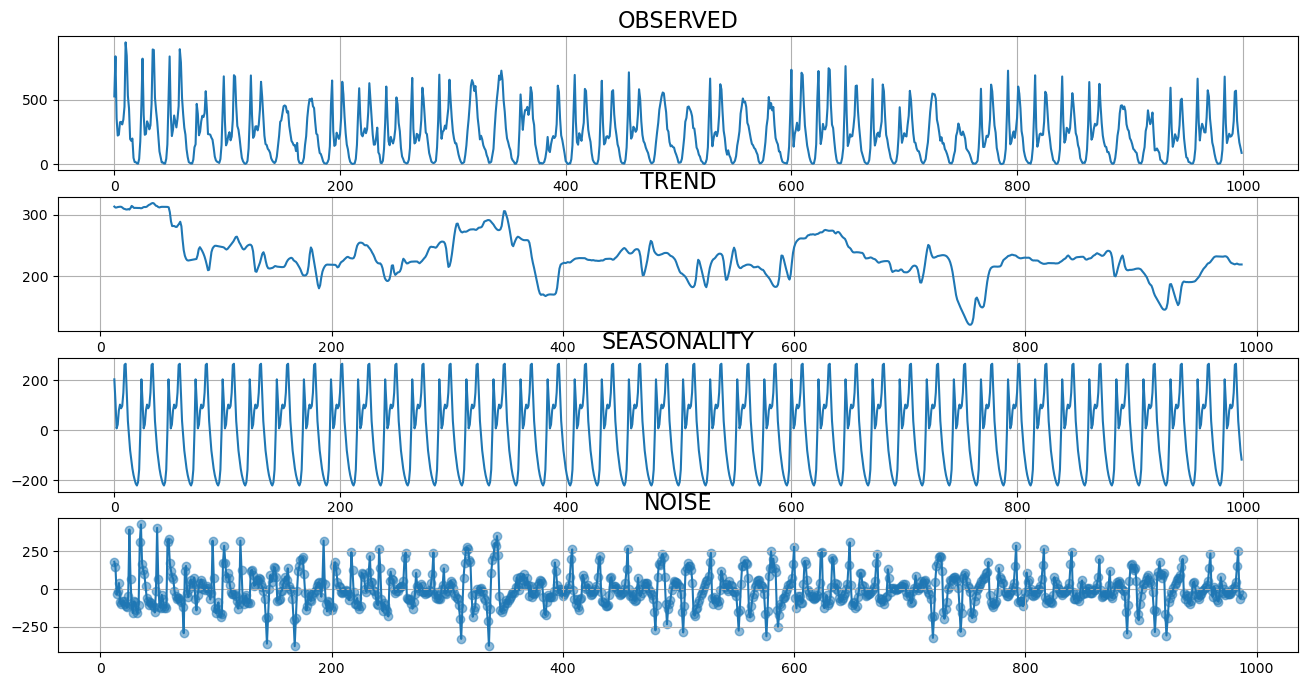

In [222]:
decompose_bike_sharing_demand(df, samples=1000, period=24)

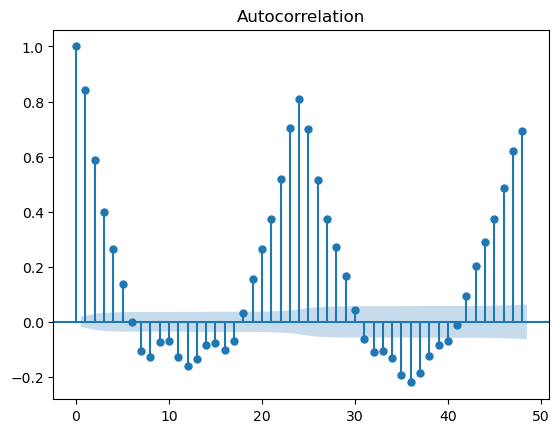

In [223]:
plot_acf(df['count'].values, lags=48)
plt.show()

# Time Series Modelling

# Microsoft's Light Gradient Boosting Machine

In [224]:
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [225]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index(df.datetime)
df.drop('datetime', axis=1, inplace=True)

df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df.drop(['casual', 'registered'], axis=1, inplace=True)

In [226]:
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,0,1,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,1,1,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2,1,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,3,1,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,19,19,12
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,20,19,12
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,21,19,12


In [227]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [228]:
def train_time_series_with_folds(df, confidence=0.9):
    X = df.drop('count', axis=1)
    y = df['count']

    maes = list()
    tscv = TimeSeriesSplit(n_splits=2, test_size=24*7)
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = LGBMRegressor(random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        mae = np.round(mean_absolute_error(y_test, predictions), 3)    
        maes.append(mae)
        
        m = predictions.mean()
        s = predictions.std()
        dof = len(predictions) - 1
        t_crit = np.abs(t.ppf((1 - confidence) / 2, dof))
        lower_conf = m - s * t_crit / np.sqrt(len(predictions))
        upper_conf = m + s * t_crit / np.sqrt(len(predictions))
        
        fig = plt.figure(figsize=(16,8))
        plt.title(f'Fold {fold} Real vs Prediction - MAE {mae}', fontsize=20)
        plt.plot(y_test, color='red')
        plt.plot(pd.Series(predictions, index=y_test.index), color='green')
        plt.fill_between(y_test.index, (predictions - lower_conf), (predictions + upper_conf), color='green', alpha=.1)
        plt.xlabel('Hour', fontsize=16)
        plt.ylabel('Number of Shared Bikes', fontsize=16)
        plt.legend(labels=['Real', 'Prediction', f'{int(confidence * 100)}% Confidence Interval'], fontsize=16)
        plt.grid()
        plt.show()
        
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()


# Train Model without Lags

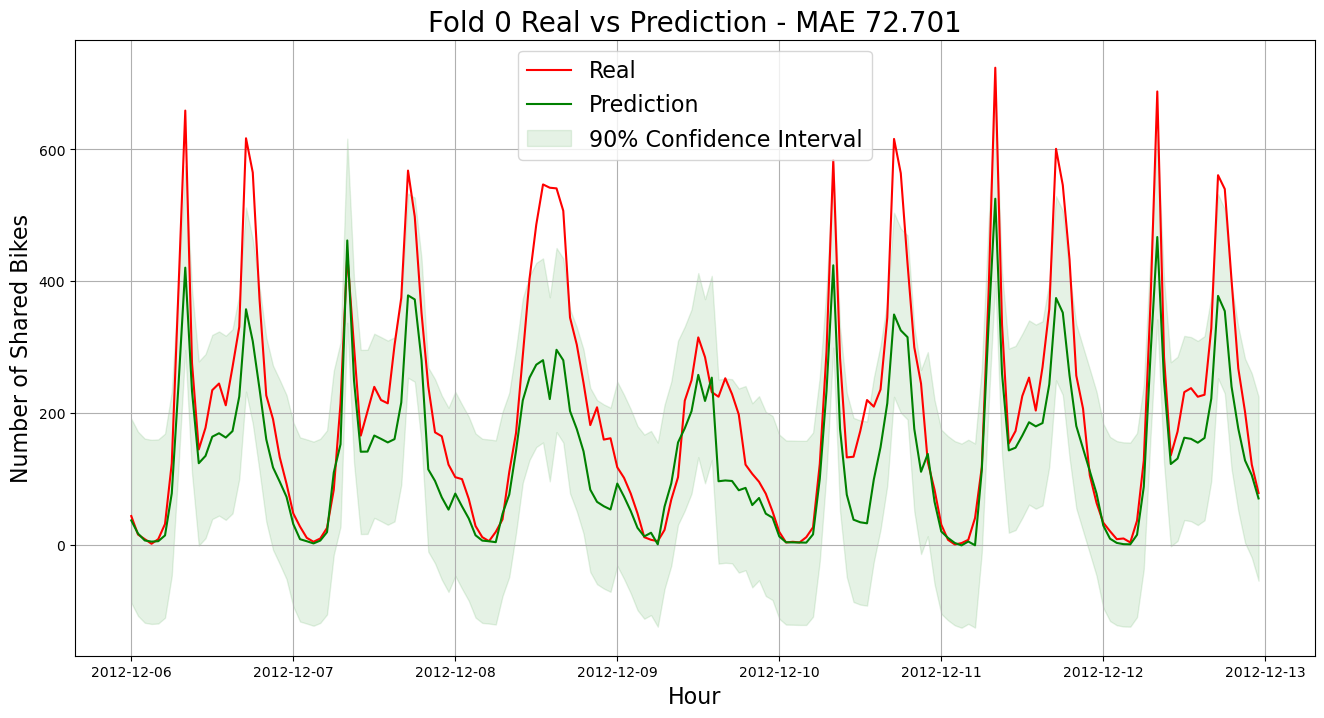

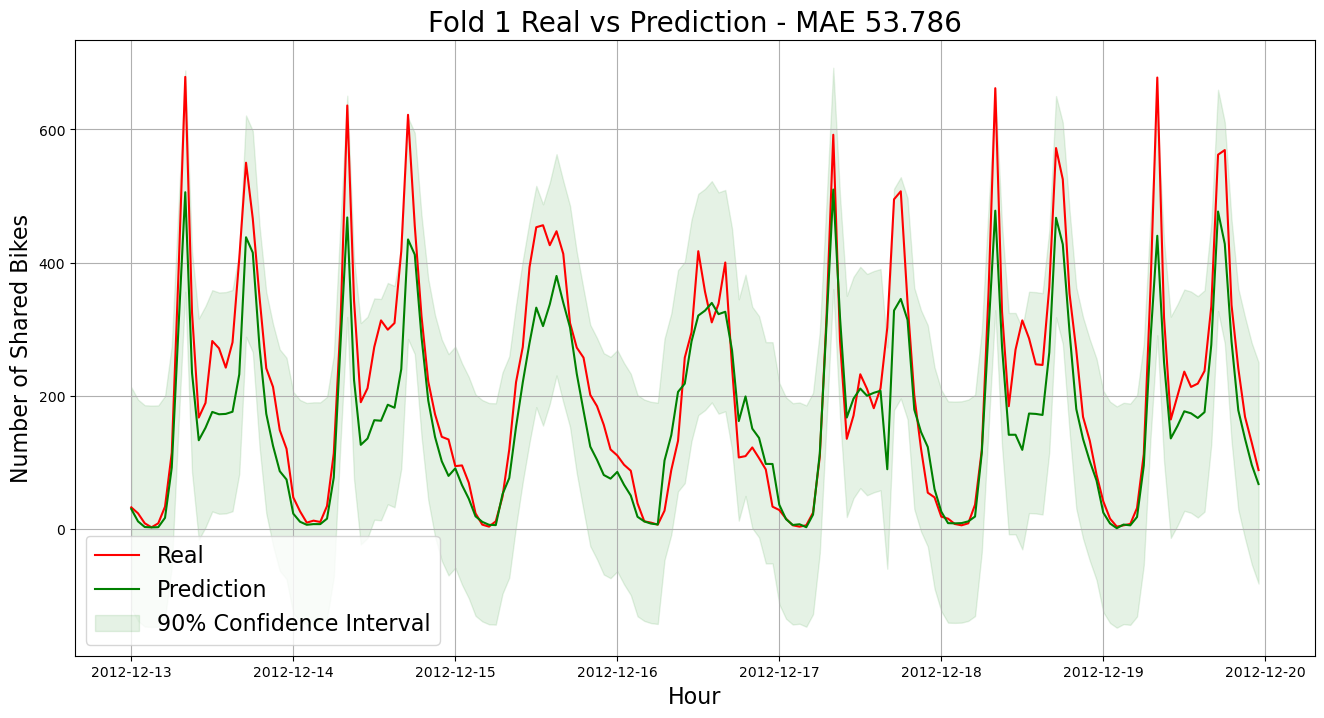

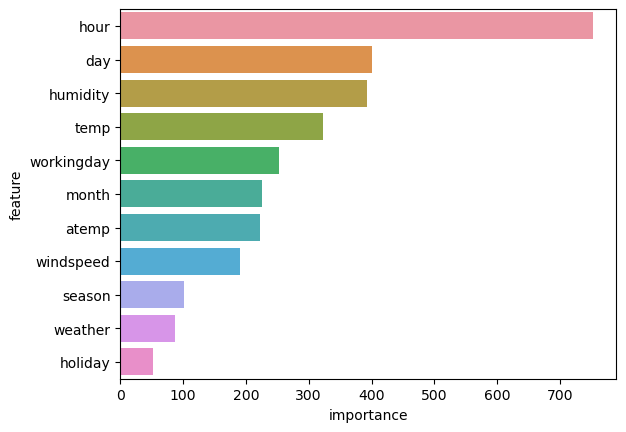

In [229]:
train_time_series_with_folds(df)

# Train Model with Lags

In [230]:
df['count_prev_week_same_hour'] = df['count'].shift(24*7)
df.dropna(how='any', axis=0, inplace=True)

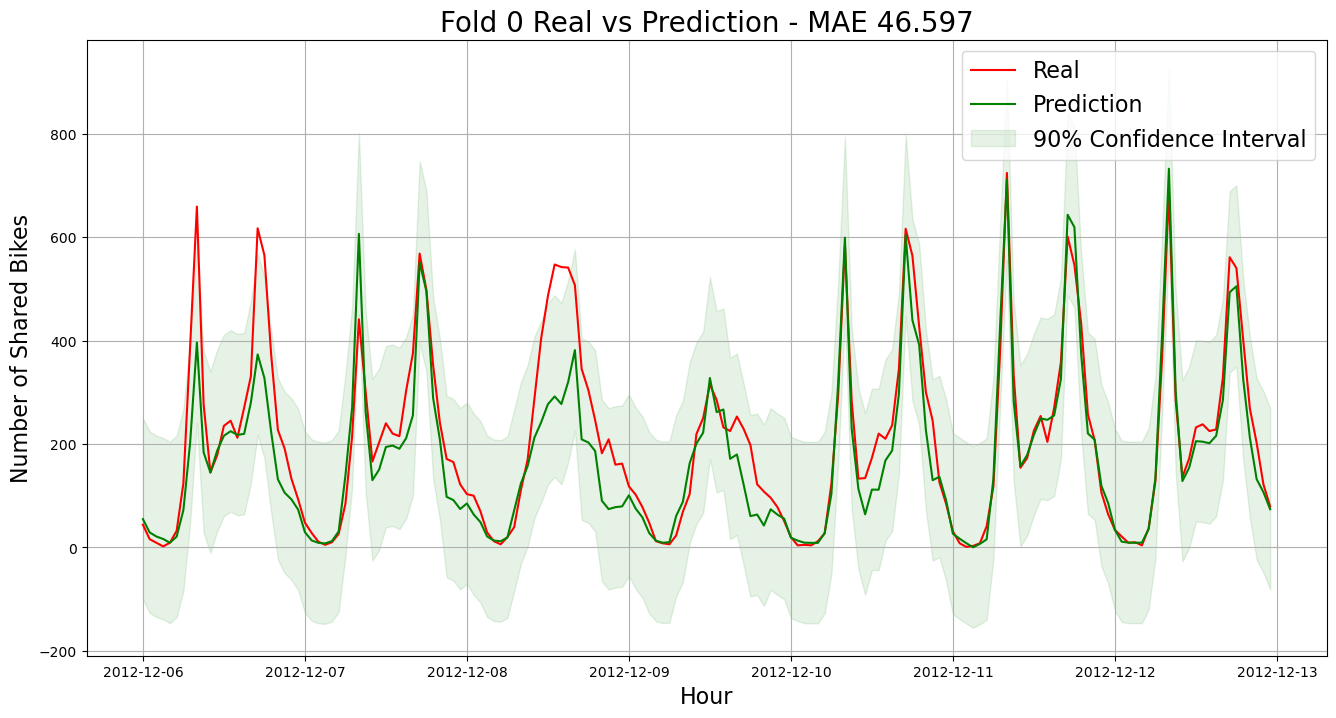

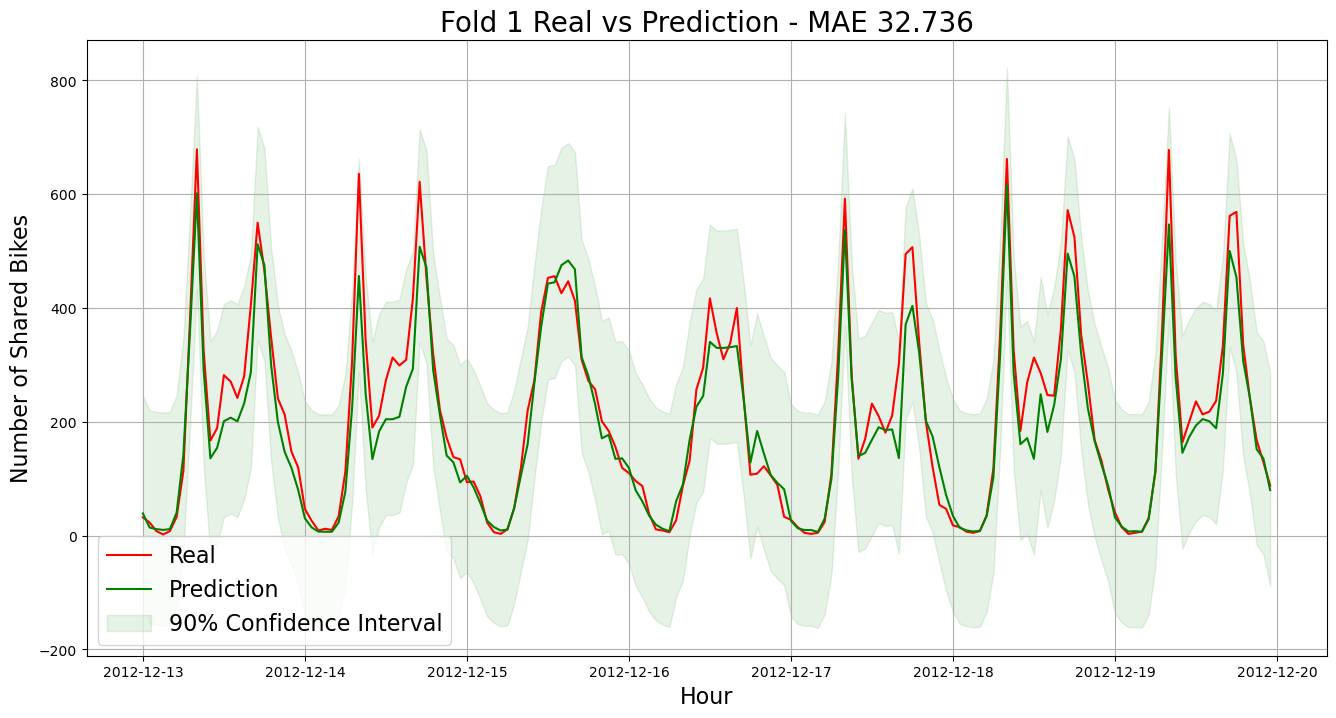

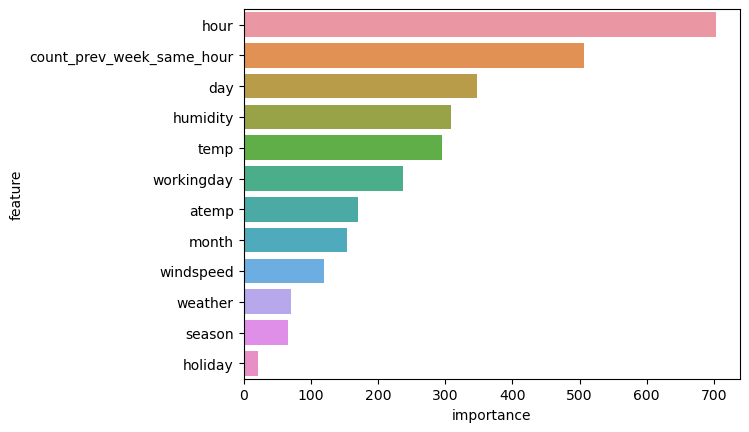

In [231]:
train_time_series_with_folds(df)